# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

C:\Users\ebbi_\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Add any additional import statements you need here
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords

sw = stopwords.words("english")

from wordcloud import WordCloud
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

import glob

from nltk.tokenize import word_tokenize
#!pip install mysql-connector-python
import mysql.connector
import html
from nltk.tokenize.treebank import TreebankWordDetokenizer

import seaborn as sns
import random


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ebbi_\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# change `data_location` to the location of the folder on your machine.
#C:/USD/MSADS/Spring 24/ADS 509/Module 2/Assignment/M1 Assignment Data/M1 Results
data_location = "C:/USD/MSADS/Spring 24/ADS 509/Module 2/Assignment/M1 Assignment Data/M1 Results/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [4]:
# Read in the lyrics data
lyrics_files = data_location + lyrics_folder

lyrics_dict = {"artist": [], "song_name": [], "lyrics": []}

for artist_folder in os.listdir(lyrics_files):
    artist_path = lyrics_files + artist_folder
    for file in os.listdir(artist_path):
        if file.endswith(".txt"):
            file_path = f"{artist_path}/{file}"
            with open(file_path, 'r') as f:
                lyrics = f.read()
                song_name = file.split("_")[1].split(".")[0] # take just song title from file name
                
                # adding data to dictionary
                lyrics_dict['artist'].append(artist_folder)
                lyrics_dict['song_name'].append(song_name)
                lyrics_dict['lyrics'].append(lyrics)


In [5]:
# Read in the twitter data

twitter_files = data_location + twitter_folder

twitter_dict = {"artist": [], "description": []}

for file in os.listdir(twitter_files):
    if file.endswith('_data.txt'):
        # saving artist name from folder name
        artist = file.split('_')[0]
        
        # saving follower_path
        file_path = twitter_files + file
        with open(file_path, 'r', encoding = "utf8") as f:
            for line in f:
                fields = line.strip().split("\t")
                description = fields[-1] # description should be last field based on last assignment instrs.
    
                # adding data to dictionary
                twitter_dict['artist'].append(artist)
                twitter_dict['description'].append(description)

In [6]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

def load_word_list(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        lines = file.readlines()
    return [line.strip() for line in lines if line.strip() and not line.startswith(";")]

# Load positive and negative words
positive_words = load_word_list("positive-words.txt")
negative_words = load_word_list("negative-words.txt")

# Assign scores to words
word_dict = {word: 1 for word in positive_words}
word_dict.update({word: -1 for word in negative_words})


In [7]:
# Create DataFrame from the provided Lyrics dictionary
lyrics_dataframe = pd.DataFrame.from_dict(lyrics_dict)

# Ensure 'lyrics' column is of string type
lyrics_dataframe['lyrics'] = lyrics_dataframe['lyrics'].astype(str)

# Clean the lyrics data
def clean_lyrics(lyrics):
    cleaned_lyrics = re.sub("u2019", "'", lyrics)
    cleaned_lyrics = re.sub("u2013", " ", cleaned_lyrics)
    cleaned_lyrics = re.sub("[^\w\s]", "", cleaned_lyrics)
    return cleaned_lyrics

lyrics_dataframe['lyrics'] = lyrics_dataframe['lyrics'].apply(clean_lyrics)

In [8]:
# Create DataFrame from the provided Tweet dictionary
twitter_dataframe = pd.DataFrame.from_dict(twitter_dict)

# Ensure 'description' column is of string type
twitter_dataframe['description'] = twitter_dataframe['description'].astype(str)


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [9]:
# your code here

def calculate_sentiment_score(text):
    total_score = 0
    word_count = 0
    lower_text = text.lower()
    tokens = word_tokenize(lower_text)
    
    for token in tokens:
        if token in word_dict:
            total_score += word_dict[token]
            word_count += 1
    
    if word_count != 0:
        return total_score / word_count
    else:
        return 0  # Return 0 if no sentiment words are found in the text

In [10]:
lyrics_dataframe['sentiment_score'] = lyrics_dataframe['lyrics'].apply(calculate_sentiment_score)
lyrics_dataframe[['artist', 'song_name', 'sentiment_score']].sample(10)

,artist,song_name,sentiment_score
110,cher,igotosleep,-0.428571
172,cher,mastersofwar,-0.185185
333,robyn,crashandburngirl,-0.750000
76,cher,forwhatitsworth,-0.090909
95,cher,holdinoutforlove,0.714286
69,cher,favouritescars,0.217391
192,cher,onesmallstep,-0.142857
279,cher,untilitstimeforyoutogo,1.000000
313,cher,youvemademesoveryhappy,0.652174
98,cher,houseisnotahome,0.200000


In [11]:
# like in the book, let's scale the scores to be between -1 and 1
lyrics_dataframe['sentiment_score_scaled'] = preprocessing.scale(lyrics_dataframe['sentiment_score'])

# now to group by artist and see the higher scores
lyrics_dataframe.groupby('artist').agg({'sentiment_score_scaled': 'mean'})

,sentiment_score_scaled
artist,
cher,-0.020540
robyn,0.062409


In [12]:
# Set option to display all lyrics
pd.set_option('display.max_colwidth', None)

# Finding songs with bottom 3 sentiment score for cher
cher_bottom3 = lyrics_dataframe[lyrics_dataframe['artist'] == "cher"].sort_values("sentiment_score").head(3)

# Finding songs with top 3 sentiment score for cher
cher_top3 = lyrics_dataframe[lyrics_dataframe['artist'] == "cher"].sort_values("sentiment_score", ascending=False).head(3)

# Finding songs with bottom 3 sentiment score for robyn
robyn_bottom3 = lyrics_dataframe[lyrics_dataframe['artist'] == "robyn"].sort_values("sentiment_score").head(3)

# Finding songs with top 3 sentiment score for robyn
robyn_top3 = lyrics_dataframe[lyrics_dataframe['artist'] == "robyn"].sort_values("sentiment_score", ascending=False).head(3)

# Displaying cher's scores and lyrics
display(cher_bottom3, cher_top3)

,artist,song_name,lyrics,sentiment_score,sentiment_score_scaled
123,cher,island,Island\n\n\n\nI think we need an island\nCause we cant get along\nIn this place that were on\nAnd honey\nWhen I wake in the morning\nIf I could see your face\nIf I could see your face\n\nChorus\nAnd Ive covered the whole world\nSearching for a way to get to you\nWill it be this way forever\nOoh I feel the night is breathing\nCloser than ever\nAnd I cant believe were no together\n\nI need to get some answers\nCause I cant understand it\nWe both know its wrong\nAnd honey\nI wanna die completely\nWeve dragging it out too long\nMuch too long\n\nChorus\n\nAnd Ive covered the whole world\nSearching for a way to get to you\nAnd I cant believe were not together\n\nI think we need an island\n,-1.0,-2.443703
218,cher,shadowdreamsong,Shadow Dream Song\n\n\n\nI meant to call her name\nI meant to take her hand\nI meant to be the same and understand\nJust what was happening\nIn the evening\nBetween the princess and the prince\nOh yeah\n\nI cant be bothered now\nCannot eat or drink\nI cant remember how I used to think\nWhat was that song she sang\nIn the morning\nAbout the princess and the prince\nYeah yeah\n\nIts a crystal ringing way\nShe has about her in the day\nShe s a laughing dapple shadow\nYes shes a laughing dapple shadow\nIn my mind\nMmm hmmmmm yeah\n\nIf I could hear her voice\nIf I could see her face\nIf I could wish and be most any place\nBe where I saw her last\nOn that evening past\nWith the princess and the prince\nYeah\n\nThe princess and the prince\n,-1.0,-2.443703
291,cher,whatllido,Whatll I Do\n\n\n\nWhatll I do when you are far away\nAnd Im so blue whatll I do\nWhatll I do when I am wondering\nWho is kissing you\nWhatll I do\n\nWhatll I do with just a photograph\nTo tell my troubles to\n\nWhen I am alone\nWith all the dreams of you\nThat wont come true\nWhat will I do\n\nWhatll I do when you are far away\nAnd I am blue whatll I do\n,-1.0,-2.443703


,artist,song_name,lyrics,sentiment_score,sentiment_score_scaled
94,cher,heyjoe,Hey Joe\n\n\n\nHey Joe where you goin\nWith that gun in your hand\nI said now\nHey Joe where you goin\nWith that gun in your hand\n\nGoin down to shoot my old lady\nCause you know\nI caught her messin round town\nIm goin down to shoot my old lady\nCause I caught her messin round\nWith another man\n\nHey Joe I heard\nYou shot your woman down shot her down\nHey I said hey Joe I heard\nYou shot your woman down\nShot her down to the ground\n\nYes I did I shot her\nCause I caught her messin round town\nHey Joe I heard\nYou shot your woman down shot her down\nWell I said oh hey Joe\nI heard you shot your woman down\nShot her down shot her down\n\nYes yes I did I shot her\nCause I caught her messin round town\nHey Joe where you gonna run to now\nI said I said hey Joe\nWhere you gonna run to now\nWhere you gonna go\nWell dude Im goin down south\nWay down to Mexico way\nI said Im goin down south\nWay down to Mexico way\n,1.0,1.753501
143,cher,justwhativebeenlookinfor,Just What Ive Been Lookin For\n\n\n\nYoure just what Ive been looking for\nSomething I never thought Id fine\nAnd everything I ever dream of\nIs getting closer all the time\n\nAh I believe you want me too\nAnd love is in your eyes\nYoure just what Ive been looking for\nJust what I had in mind\n\nOnce around the wheel of love\nI guess everybodys tried\nAnd you never quit get over it\nWhen youve been taken for a ride\n\nWell forget all that\nThats another place and another time\nThat world began to fade away\nWhen you walked into my life\n\nYoure just what Ive been looking for\nSomething I never thought Id fine\nAnd everything I ever dream of\nIs getting closer all the time\n\nAh I believe you want me too\nAnd love is in your eyes\nYoure just what Ive been looking for\nJust what I had in mind\n\nYoure just what Ive been looking for\nJust what I had in mind\n,1.0,1.753501
114,cher,iknowyoudontloveme,I Know You Dont Love Me\n\n\n\nUh uh uh\nYou dont love me\nYes I know\nUhuhuh\nYou dont love me\nYes I know\n\nWell you left me pretty baby\nAnd I had no place to go\nYes I love you\nIll do anything you say\nYes I love you\nIll do anything you say\nIf you say you love me baby\nIll get on my knees and pray\n\nUh uh uh\nYou dont love me\nYes I know\n,1.0,1.753501


In [13]:
# displaying Robyn's

display(robyn_bottom3, robyn_top3)

,artist,song_name,lyrics,sentiment_score,sentiment_score_scaled
343,robyn,dontfuckingtellmewhattodo114520,Dont Fucking Tell Me What To Do\n\n\n\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\n\nMy smoking is killing me\nMy diet is killing me\nMy heels are killing me\nMy shoppings killing me\nMy ego is killing me\nCant sleep its killing me\nMy labels killing me\nKickdrum\n\nMy phone is killing me\nMy email is killing me\nThese hours are killing me\nMy tour is killing me\nThis flight is killing me\nMy managers killing me\nMy mothers killing me\nMy landlords killing me\nMy boss is killing me\nThe TV is killing me\nYour nagging is killing me\nMy boyfriends killing me\nMy talkings killing me\nKilling me\nKilling me\n\nCant sleep its killing me\nMy dreams are killing me\nTV is killing me\nMy talkings killing me\nLet go youre killing me\nEase up youre killing me\nCalm down youre killing me\nMy god youre killing me\n\nMy drinking is killing me\nMy smoking is killing me\nMy head is killing me\nMy mind is killing me\nMy back is killing me\nMy neck is killing me\nYour nagging is killing me\nMy gut is killing me\nMy PMS is killing me\nMy email is killing me\nThese hours are killing me\nMy tour is killing me\nThis flight is killing me\nMy managers killing me\nMy mothers killing me\nMy landlords killing me\nMy smoking is killing me\nThe TV is killing me\nYour nagging is killing me\nEase up youre killing me\nLet go youre killing me\nCalm down youre killing me\nMy god youre killing me\n\nDont fucking tell me what to do do\nDont fucking tell me what to do do do do do\nDont fucking tell me what to do\nDont fucking tell me what to do do\nDont fucking tell me what to do do\nDont fucking tell me what to do\nDont fucking tell me what to do\nDont fucking tell me what to do\nDont fucking tell me what to do\n,-0.905882,-2.246187
342,robyn,dontfuckingtellmewhattodo,Dont Fucking Tell Me What To Do\n\n\n\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\n\nMy smoking is killing me\nMy diet is killing me\nMy heels are killing me\nMy shoppings killing me\nMy ego is killing me\nCant sleep its killing me\nMy labels killing me\nKickdrum\n\nMy phone is killing me\nMy email is killing me\nThese hours are killing me\nMy tour is killing me\nThis flight is killing me\nMy managers killing me\nMy mothers killing me\nMy landlords killing me\nMy boss is killing me\nThe TV is killing me\nYour nagging is killing me\nMy boyfriends killing me\nMy talkings killing me\nKilling me\nKilling me\n\nCant sleep its killing me\nMy dreams are killing me\nTV is killing me\nMy talkings killing me\nLet go youre killing me\nEase up youre killing me\nCalm down youre killing me\nMy god youre killing me\n\nMy drinking is killing me\nMy smoking is killing me\nMy head is killing me\nMy mind is killing me\nMy back is killing me\nMy neck is killing me\nYour nagging is killing me\nMy gut is killing me\nMy PMS is killing me\nMy email is killing me\nThese hours are killing me\nMy tour is killing me\nThis flight is killing me\nMy managers killing me\nMy mothers killing me\nMy landlords killing me\nMy smoking is killing me\nThe TV is killing me\nYour nagging is killing me\nEase up youre killing me\nLet go youre killing me\nCalm down youre killing me\nMy god youre killing me\n\nDont fucking tell me 

,artist,song_name,lyrics,sentiment_score,sentiment_score_scaled
419,robyn,youvegotthatsomething,Youve Got That Something\n\n\n\nLook at me here I am\nIm givin all of my lovin every day of my life to you\nAll you see can be yours\nIf you show me you love me just one little hint will do\n\nAnd I know\nI give too much and there is much I sacrifice\nBut Ive got all the reasons\nwhen I look into your eyes\nI know I love you even though I shouldnt and you should know\nIve tried to stop\nYouve got that somethin\nGives me that feelin\nGives me that freaky vibe\n\nYouve got that something that makes me feel so fine\nMakes it worth waiting until the day that you will be mine all mine\n\nYou decide take your time\nI just want you to know that Ill always be here for you\nMy friends keep tellin me\nyouve gotta let go\nThey say Im too good for you and maybe that is true\n\nBut I just keep on lovin you the way I did before\nAnd you should know Ive tried to stop\n,1.0,1.753501
404,robyn,stars4ever,Stars 4Ever\n\n\n\nYou and me together \nStars forever 4x\n\nYou and me on the hood\nOn my car\nSaturday night\nWatching the stars 2x\n\nYou and I\nShinning lights to what we are\nLook at the sky\nAnd I am never far\n\nI can be right there next to you\nNo matter where in the world you are\nI got you right here next to me\nForever connected through the stars\n\nIts what we are\n\nYou and me together \nStars forever 4x\n\nThe last trains gone\nWe walk through the night\nThe moon shines down\nLike a spotlight 2x\n\nYou and I\nShinning lights to what we are\nLook at the sky\nAnd I am never far\n\nI can be right there next to you\nNo matter where in the world you are\nI got you right here next to me\nForever connected through the stars\n\nIts what we are\n\nYou and me together \nStars forever 4x\n\nIts what we are\n\nYou and me together \nStars forever 4x\n\nI can be right there next to you\nI can be right there next to you\nForever connected through the stars\nIts what we are\n\nYou and me together \nStars forever 4x\n\nWere superstars\n\nYou and me together \nStars forever 4x\n\nStars forever\n,1.0,1.753501
371,robyn,inmyheart,In My Heart\n\n\n\nHope things will get better cause thats what I need\nI think about the good times that we had and now I see that you are\nliving in two different places and I dont think its gonna be a change\n\nBut Im never gonna leave it Im always gonna keep it In my heart\nIn my heart\nIll keep it all together\nIn my heart\nI know its gonna be better\nIn my heart\n\nYou said that it should never be like this and\nwhen I was a little child I never had this on my mind\nBut now it is like it is and I dont think its gonna be a change\n\nBut Im never gonna leave it Im always gonna keep it \nIn my heart\n,1.0,1.753501


### Questions

Q: Overall, which artist has the higher average sentiment per song? 

A:  Analyzing the sentiment scores, Cher's average sentiment score is 0.154656, while Robyn's is slightly higher at 0.194182. However, when considering the scaled sentiment scores, Cher's average sentiment score is -0.020540, while Robyn's is higher at 0.062409. Therefore, although Cher initially seemed to have a lower sentiment score, after scaling, Robyn emerges with the higher average sentiment score.



In [14]:
lyrics_dataframe.groupby('artist').agg({'sentiment_score':'mean'})

,sentiment_score
artist,
cher,0.154656
robyn,0.194182


In [15]:
lyrics_dataframe.groupby('artist').agg({'sentiment_score_scaled':'mean'})

,sentiment_score_scaled
artist,
cher,-0.020540
robyn,0.062409


---

#### Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: For Cher, the three songs with the highest sentiments are "Hey Joe", "Just what I've been looking for", and "I Know you don't love me." Conversely, the three songs with the lowest sentiments are "Island", "Shadow Dreaming", and "What'll I Do."

Examining "Hey Joe," the lyrics depict a narrative of longing and desire, which could contribute to its positive sentiment. Conversely, "Island" portrays themes of separation and yearning, potentially leading to its negative sentiment score.

In "Just what I've been looking for," there's a sense of fulfillment and contentment, likely influencing its positive sentiment. On the other hand, "Shadow Dreaming" delves into introspection and uncertainty, possibly contributing to its lower sentiment score.

"I Know you don't love me" suggests acceptance and acknowledgment, which could contribute to its positive sentiment. Conversely, "What'll I Do" portrays vulnerability and longing, potentially leading to its negative sentiment.

Overall, these sentiment scores seem to reflect the emotional themes present in each song. Cher's songs exhibit a range of sentiments, reflecting the complexities of human emotions within her music.

---

#### Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: For Robyn, the three songs with the highest sentiments are "You've got that something," "Stars 4 ever," and "In my heart." Conversely, the three songs with the lowest sentiments are "Don't fucking tell me what to do," "Criminal Intent," and "What'll I Do."

Analyzing "You've got that something," the lyrics convey themes of affection and admiration, likely contributing to its positive sentiment. Conversely, "Don't fucking tell me what to do" expresses defiance and frustration, potentially leading to its negative sentiment score.

In "Stars 4 ever," there's a sense of euphoria and celebration, likely influencing its positive sentiment. On the other hand, "Criminal Intent" delves into darker themes of conflict and wrongdoing, possibly contributing to its lower sentiment score.

"In my heart" suggests introspection and vulnerability, which could contribute to its positive sentiment. Conversely, "What'll I Do" portrays longing and uncertainty, potentially leading to its negative sentiment.

Overall, these sentiment scores seem to align with the emotional content of each song in Robyn's repertoire. They reflect the diverse range of themes and moods present in her music, from moments of joy and celebration to introspection and defiance.

---

#### Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a len

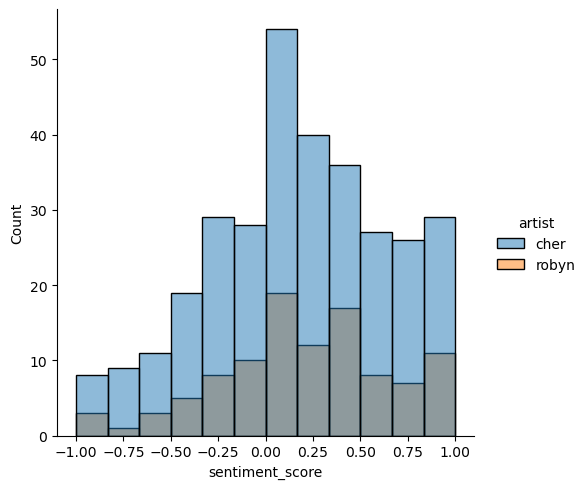

In [16]:
# Raw Sentiment Scores
sns.displot(data=lyrics_dataframe, x="sentiment_score", hue="artist", kind="hist")

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a len

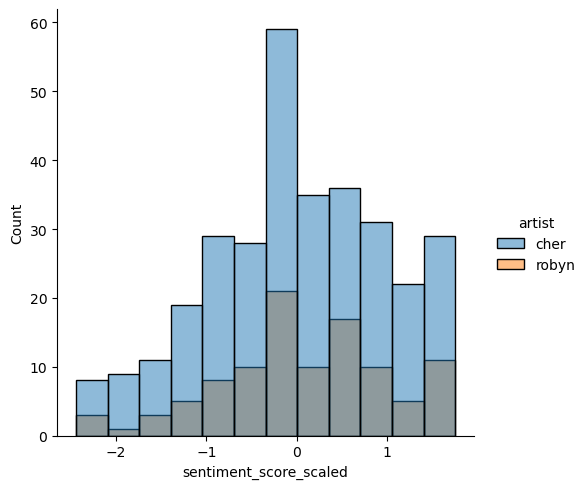

In [17]:
# Scaled Sentiment Scores
sns.displot(data=lyrics_dataframe, x="sentiment_score_scaled", hue="artist", kind="hist")

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [18]:
twitter_dataframe.sample(5)

,artist,description
3439815,cher,1045
2299614,cher,disable us navy vet
2276624,cher,livin in the 3rd district of Chormatica planet 🪐
3138436,cher,21
2477021,cher,Livin the dream :P .. music - the language that comforts the soul ..


In [19]:
import emoji

pos_emojis = [emoji.emojize(':joy:'), # laughing, crying face
              emoji.emojize(':heart:'), # heart
              emoji.emojize(':heart_eyes:'), # heart-eyes
              emoji.emojize(':blush:'), # smiling, blushing face
              emoji.emojize(':kissing_heart:'), # kissing face
              emoji.emojize(':fire:'), # fire emoji
              emoji.emojize(':relaxed:'), # another smiling, blushing , relaxed face
              emoji.emojize(':+1:'), # thumbs up emoji
              emoji.emojize(':sparkles:'), # four stars/sparkles
              emoji.emojize(':sunglasses:'), #smiling face with sunglasses
              emoji.emojize(':purple_heart:'), # purple heart
              emoji.emojize(':blue_heart:'), 
              "💜", "🌈", "❤", "♥", "✨", "✌", "❤️", "😍", "👯", "💞"] # blue heart


neg_emojis = [emoji.emojize(':pensive:'), # pensive, remorseful face
             emoji.emojize(':unamused:'),
             emoji.emojize(':weary:'),
             emoji.emojize(':broken_heart:'),
              emoji.emojize(':cry:'),
              emoji.emojize(':disappointed:'),
              emoji.emojize(':expressionless:'),
              emoji.emojize(':confused:'),
              emoji.emojize(':rage:'), # red, angry face
              emoji.emojize(':grimacing:'),
              emoji.emojize(':angry:'),
              emoji.emojize(':confounded:'),
              "🤡", "😠", "😭", "💀", "😖", "💢", "❌", "😑", "😓", "✋"]
              

In [20]:
# Setting up scores for emojis
emoji_dict = {}

for emoji in pos_emojis:
    emoji_dict[emoji] = 1

for emoji in neg_emojis:
    emoji_dict[emoji] = -1

# Function to extract emojis
def extract_emojis(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return ''.join(emoji_pattern.findall(text))

emoji_dict

{':joy:': 1,
 ':heart:': 1,
 ':heart_eyes:': 1,
 ':blush:': 1,
 ':kissing_heart:': 1,
 '🔥': 1,
 ':relaxed:': 1,
 ':+1:': 1,
 '✨': 1,
 '🕶️': 1,
 '💜': 1,
 '💙': 1,
 '🌈': 1,
 '❤': 1,
 '♥': 1,
 '✌': 1,
 '❤️': 1,
 '😍': 1,
 '👯': 1,
 '💞': 1,
 ':pensive:': -1,
 ':unamused:': -1,
 ':weary:': -1,
 '💔': -1,
 ':cry:': -1,
 ':disappointed:': -1,
 ':expressionless:': -1,
 ':confused:': -1,
 ':rage:': -1,
 ':grimacing:': -1,
 ':angry:': -1,
 ':confounded:': -1,
 '🤡': -1,
 '😠': -1,
 '😭': -1,
 '💀': -1,
 '😖': -1,
 '💢': -1,
 '❌': -1,
 '😑': -1,
 '😓': -1,
 '✋': -1}

In [21]:

# Extracting emojis from descriptions
emoji_descriptions = []

for description in twitter_dataframe['description']:
    emoji_text = extract_emojis(description)
    emoji_descriptions.append(emoji_text)

# Adding emoji field to the dataframe
twitter_dataframe['emojis'] = emoji_descriptions

# Function to calculate sentiment score based on emojis
def calculate_emoji_score(emojis):
    score = 0
    emoji_list = [char for char in emojis]
    for emoji in emoji_list:
        if emoji in emoji_dict:
            score += emoji_dict[emoji]
    return score

# Applying emoji sentiment score function to dataframe
twitter_dataframe['emoji_score'] = twitter_dataframe['emojis'].apply(calculate_emoji_score)

# Filtering dataframe for rows with at least one emoji
tweet_df_with_emojis = twitter_dataframe[twitter_dataframe['emojis'] != '']

# Grouping by artist and calculating average emoji sentiment score
artist_emoji_sentiment_avg = tweet_df_with_emojis.groupby('artist').agg({'emoji_score': 'mean'})

# Calculating average sentiment score for all descriptions, with or without emojis
overall_artist_sentiment_avg = twitter_dataframe.groupby('artist').agg({'emoji_score': 'mean'})


In [22]:
tweet_df_with_emojis.sample(5)


,artist,description,emojis,emoji_score
3990980,cher,"I want a little more bass... Irish implant, loving my work in London 🏳️‍🌈",🏳️🌈,1
1391514,cher,SC👻 Brandi_d16 -- God made you who you are so why not embrace it ❤️ Love to adventure 🌎,👻❤️🌎,1
100351,cher,ojalá no me bajen esta cuenta lol att: m tu mejor amix ✿,✿,0
488166,cher,Full Spectrum Organic CBD Oil & CBD Topicals ▪️Direct to Consumer ▪️Wholesale ▪️Private Label ▪️100% Lab Tested ▪️100% Non GMO #keepit100 #reliefmatters,▪️▪️▪️▪️▪️,0
627890,cher,A jetsetter with a passion for advertising. ✈️,✈️,0


In [23]:
display(artist_emoji_sentiment_avg, overall_artist_sentiment_avg)

,emoji_score
artist,
cher,0.634133
robynkonichiwa,0.607368


,emoji_score
artist,
cher,0.064237
robynkonichiwa,0.050188


Q: What is the average sentiment of your two artists? 

A: The average sentiment of the two artists for the emoji score are above, and we can see that Cher has higher sentiment results from her tweet descriptions, although it is a fairly close call.

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: Based on the analysis, the most popular positive emoji for both Cher and Robyn is the heart emoji ('❤️'), with 11970 occurrences for Cher and 835 occurrences for Robyn. Conversely, the most common negative emoji for Cher is the broken heart emoji ('💔'), appearing 273 times, while for Robyn, it is the skull emoji ('💀'), appearing 18 times.

In [24]:
from collections import Counter

def most_positive_emoji(emojis):
    emoji_count = Counter(emojis)
    pos_emojis_count = [emoji for emoji in emojis if emoji in pos_emojis]
    pos_emoji_count = Counter(pos_emojis_count)
    return pos_emoji_count.most_common(1)

def most_negative_emoji(emojis):
    emoji_count = Counter(emojis)
    neg_emojis_count = [emoji for emoji in emojis if emoji in neg_emojis]
    neg_emoji_count = Counter(neg_emojis_count)
    return neg_emoji_count.most_common(1)

cher_emojis = tweet_df_with_emojis[tweet_df_with_emojis['artist'] == 'cher']['emojis']
robyn_emojis = tweet_df_with_emojis[tweet_df_with_emojis['artist'] == 'robynkonichiwa']['emojis']

cher_most_positive = most_positive_emoji(cher_emojis)
cher_most_negative = most_negative_emoji(cher_emojis)

robyn_most_positive = most_positive_emoji(robyn_emojis)
robyn_most_negative = most_negative_emoji(robyn_emojis)

print("Cher's most positive emoji:", cher_most_positive, 
      "Cher's most negative emoji:", cher_most_negative,
      "Robyn's most positive emoji:", robyn_most_positive, 
      "Robyn's most negative emoji:", robyn_most_negative)


Cher's most positive emoji: [('❤️', 11970)] Cher's most negative emoji: [('💔', 273)] Robyn's most positive emoji: [('❤️', 835)] Robyn's most negative emoji: [('💀', 18)]
